# League of Legends Win Prediction with XGBoost

This notebook uses the Kaggle dataset [League of Legends Ranked Matches](https://www.kaggle.com/paololol/league-of-legends-ranked-matches) which contains 180,000 ranked games of League of Legends starting from 2014. Using this data we build an XGBoost model to predict if a player's team will win based off statistics of how that player played the match.

The methods used here are applicable to any dataset, we use this dataset to illustrate how SHAP values help make gradient boosted trees such as XGBoost interpretable because it is large, has many interaction effects, contains both categorical and continous values, and the features are interpretable (particularly for players of the game). 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

shap.initjs()

## Load the dataset

To run this yourself you will need to download the dataset from Kaggle and ensure the `prefix` variable below is correct.

In [2]:
# read in the data
prefix = "data/league-of-legends-ranked-matches/"
matches = pd.read_csv(prefix+"matches.csv")
participants = pd.read_csv(prefix+"participants.csv")
stats1 = pd.read_csv(prefix+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(prefix+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats = pd.merge(a, stats, left_on="matchid", right_on="id")

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
    
X = allstats.drop(["win"], axis=1)
y = allstats["win"]

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt.as_matrix(),label=yt.as_matrix())
dv = xgb.DMatrix(Xv.as_matrix(),label=yv.as_matrix())

## Train the XGBoost model

In [ ]:
params = {
    "eta": 0.2,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], verbose_eval=25)

[0]	train-logloss:0.618377	valid-logloss:0.618588


## Explain the XGBoost model

Because the Tree SHAP algorithm is implemented in XGBoost we can compute exact SHAP values quickly over thousands of samples. The SHAP values for a single prediction sum

In [40]:
# compute the SHAP values for every prediction in the validation dataset
shap_values = model.predict(dv, pred_contribs=True)

### Explain a single player's chances of winning

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implmementation the margin output of the model is explained, not the trasformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

In [39]:
shap.visualize(shap_values[0,:], feature_names=Xv.columns, data=Xv.iloc[0,:])

AttributeError: 'dict' object has no attribute 'labelMargin'

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the log odds prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a singel feature (such as `goldearned`) on a row, where the x-axis is the SHAP value. By doing this for all features, we see which features drive the model's prediction a lot (such as `goldearned`), and which only effect the prediction a little (such as `kills`).

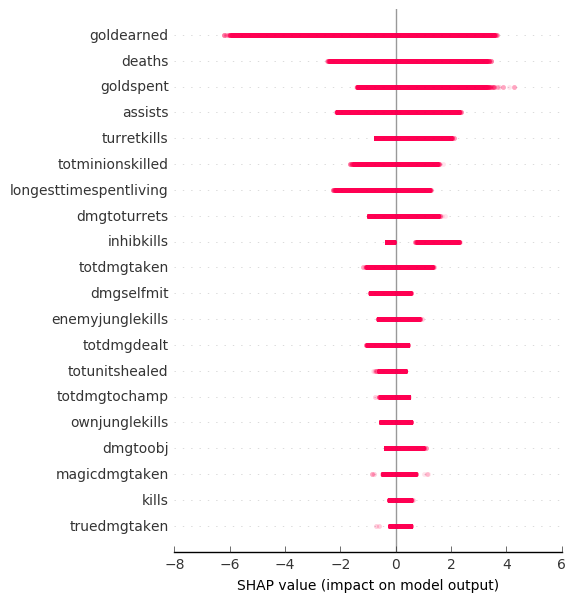

In [42]:
shap.summary_plot(shap_values, Xv.columns, max_display=20)

## Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of feature for all players we can see how changes in the feature's value effect the model's output. Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is capture by the vertical dispersion of the data points. For example earning only 5,000 gold during a game may lower your logg odds of winning by 6 for some players or only 3 for others. Why is this? Because other features of these players effect how much earning gold matters for winning the game. Note that the vertical spread narrows once you earn 20,000 gold, meaning the context of other features matters less for high gold earners than low gold earners.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2. 

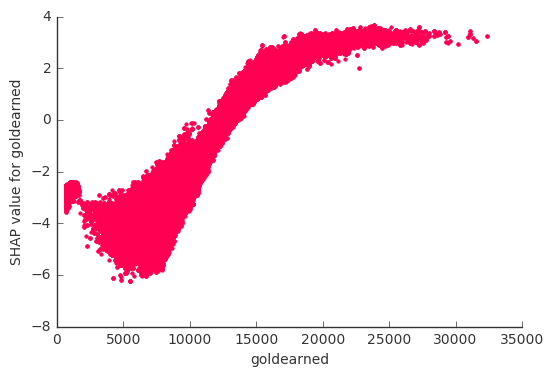

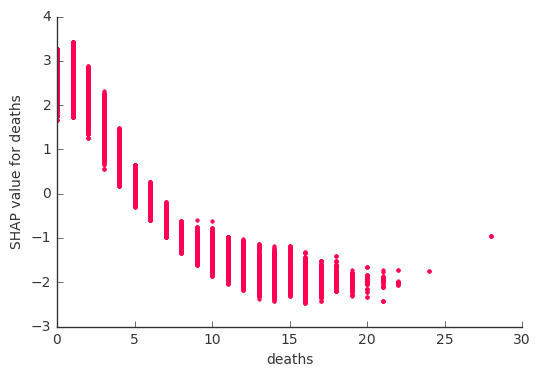

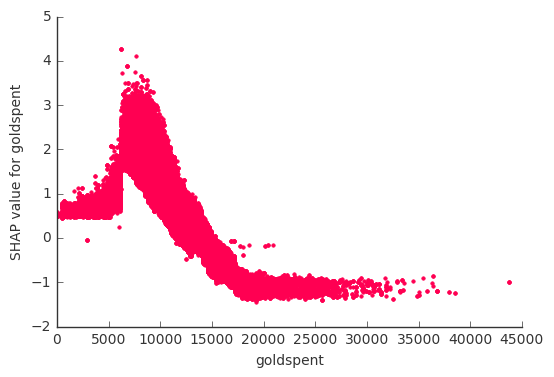

In [46]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(3):
    shap.plot(Xv.iloc[:,top_inds[i]], shap_values[:,top_inds[i]], Xv.columns[top_inds[i]])

## Using color to highlight interaction effects

Here we use and `interaction_plot` version of the SHAP plots to color the datapoints with another feature that most explains the interaction effect variance. For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

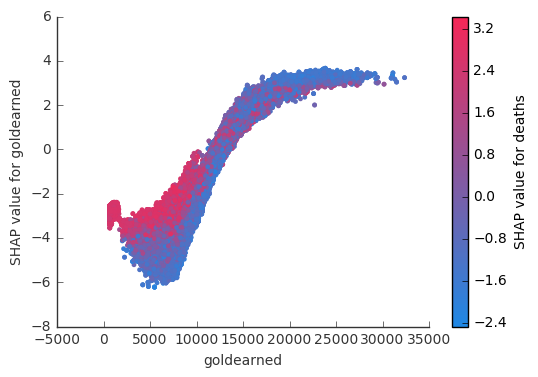

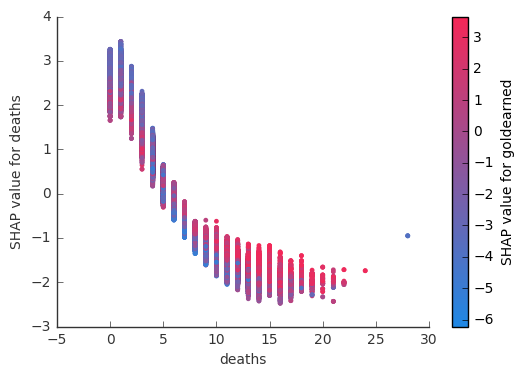

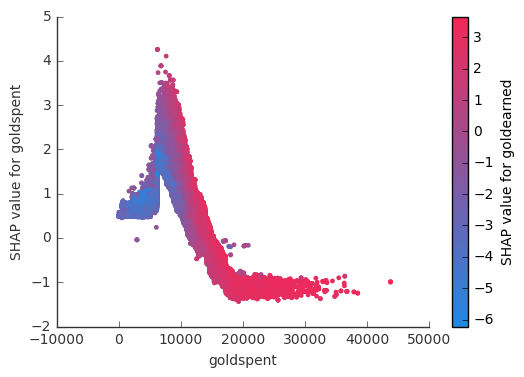

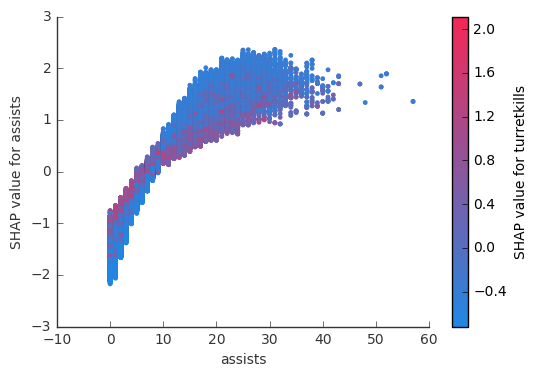

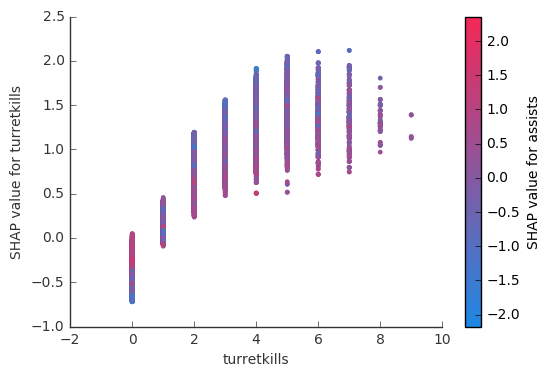

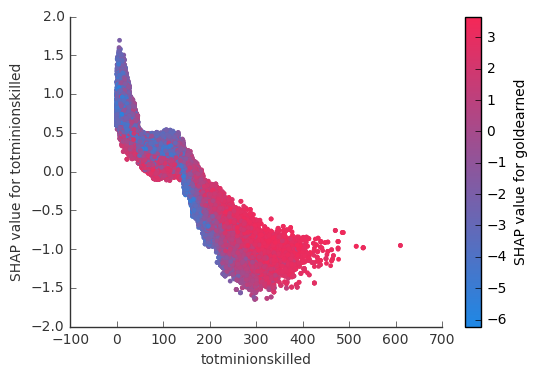

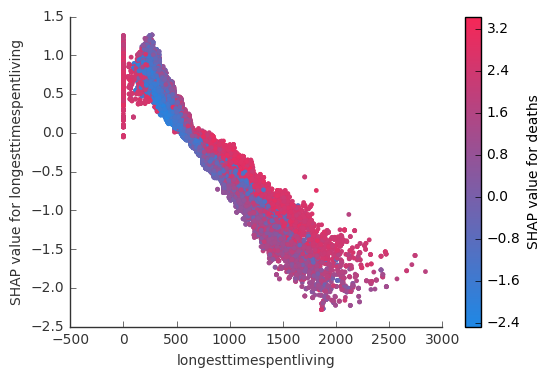

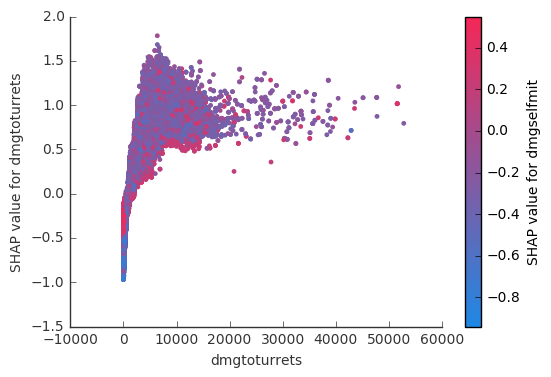

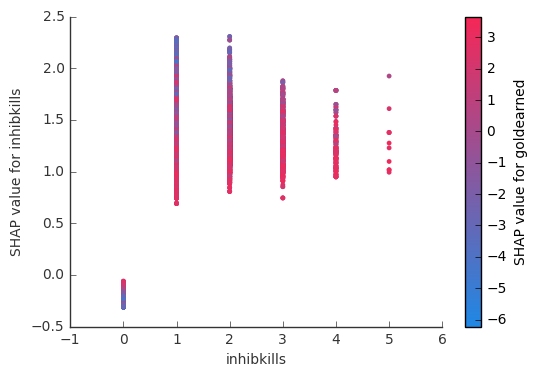

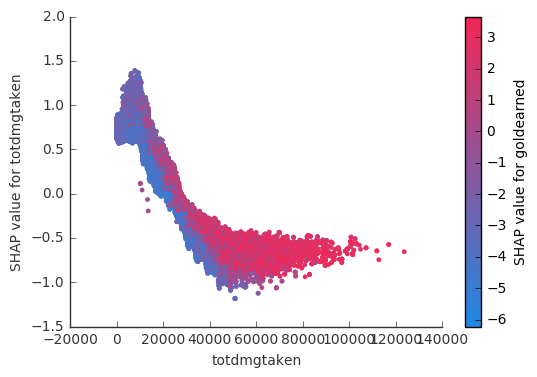

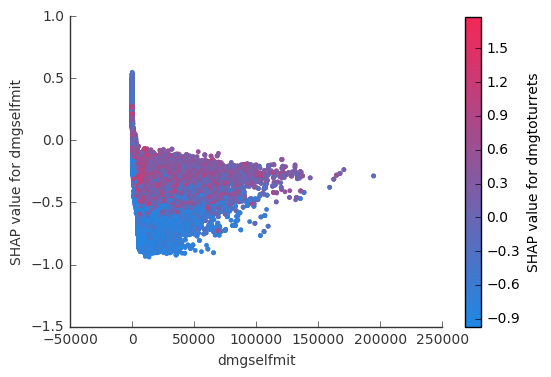

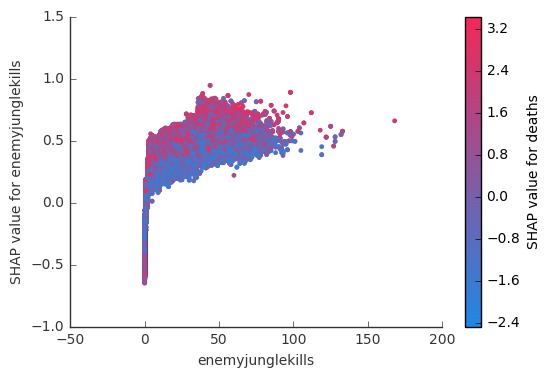

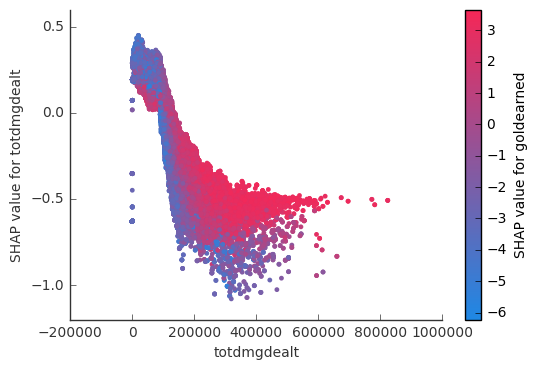

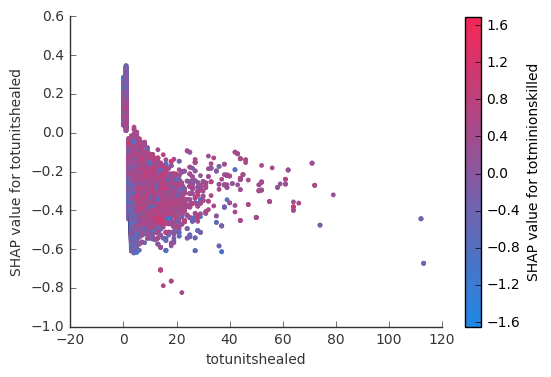

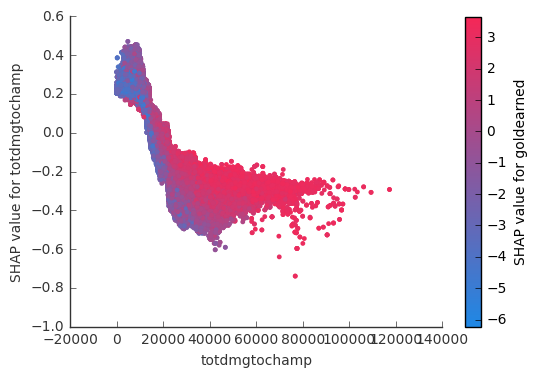

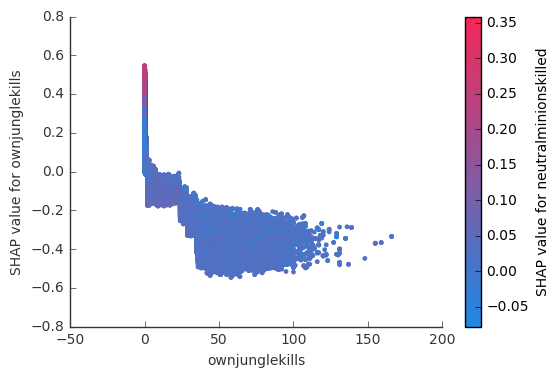

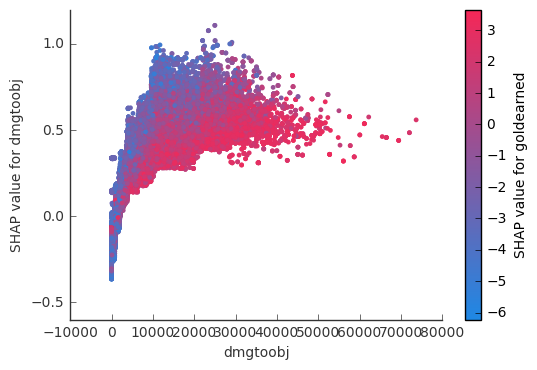

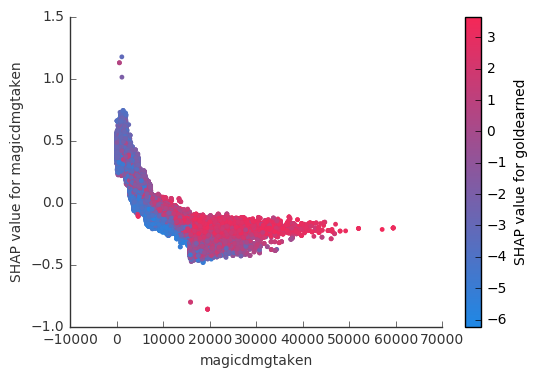

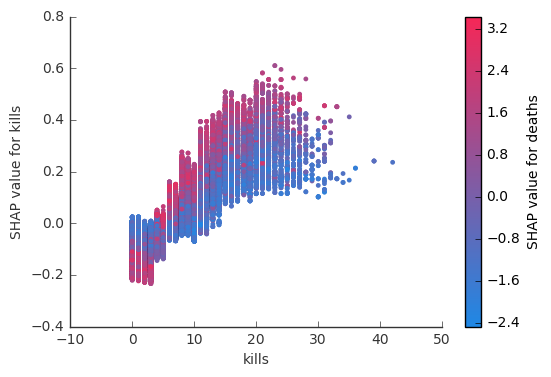

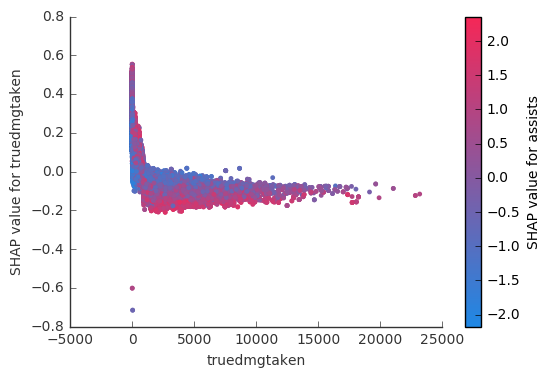

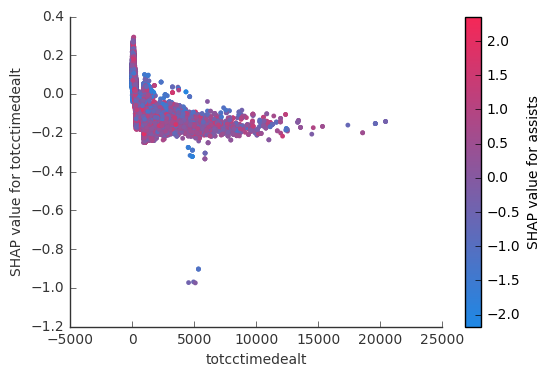

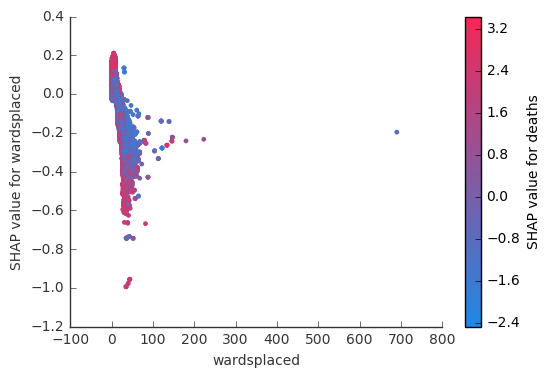

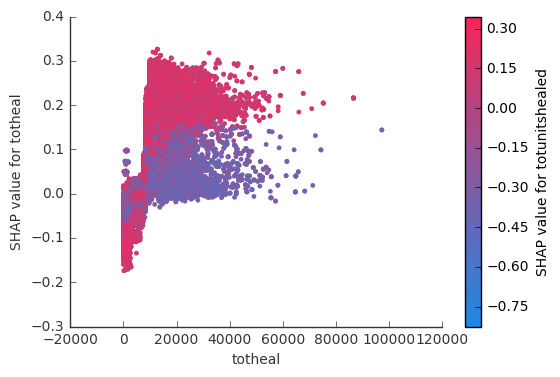

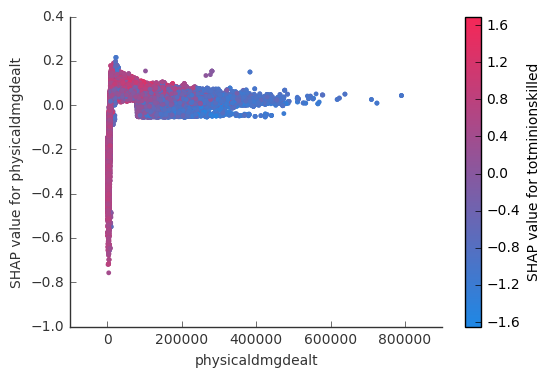

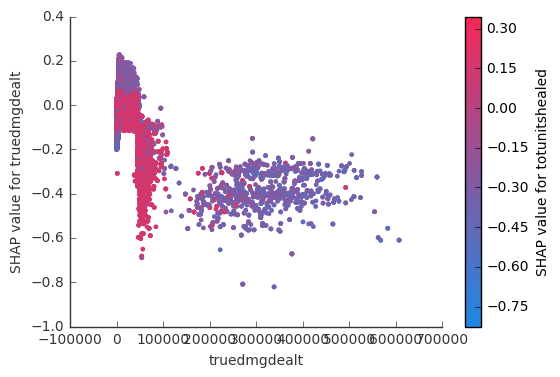

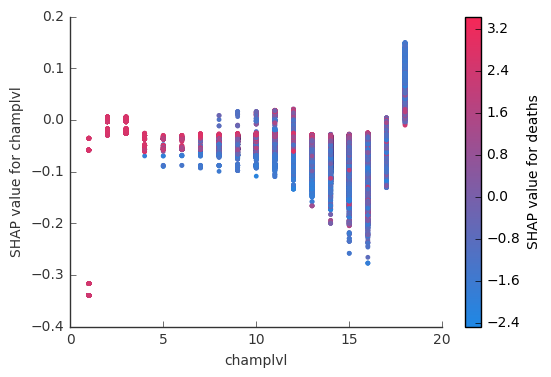

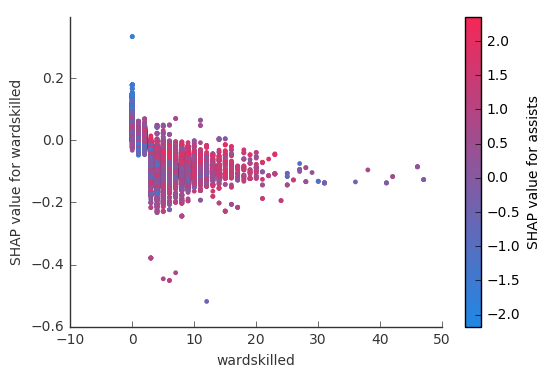

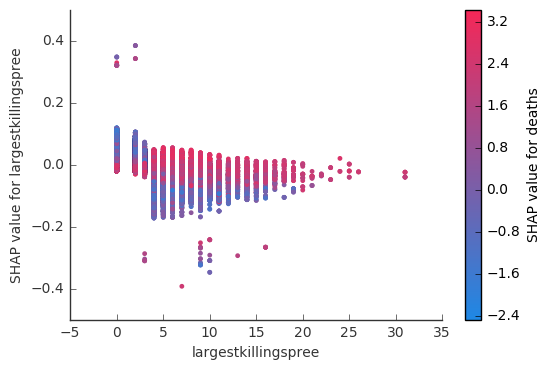

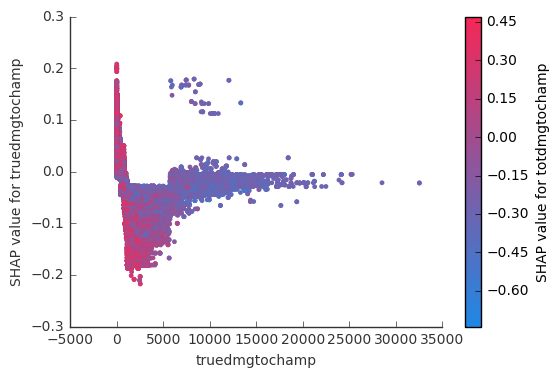

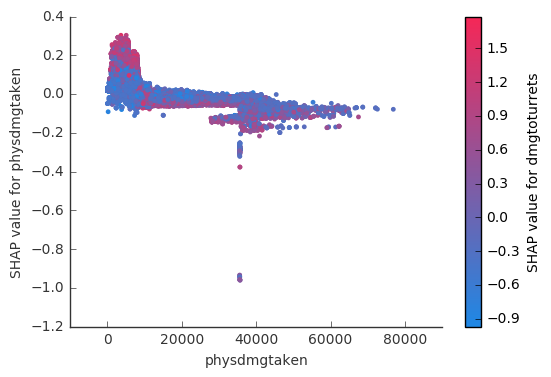

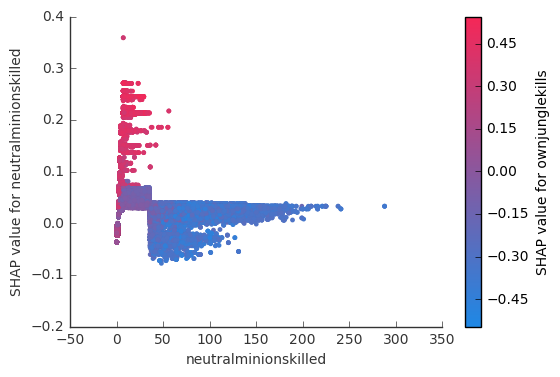

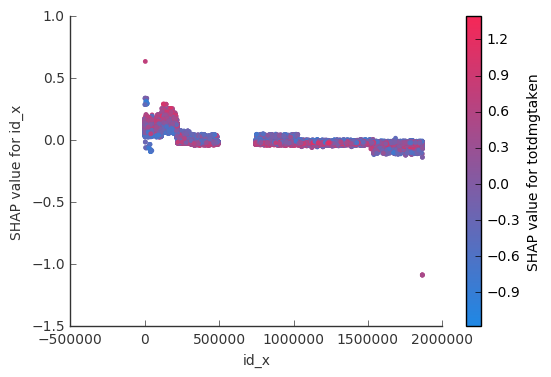

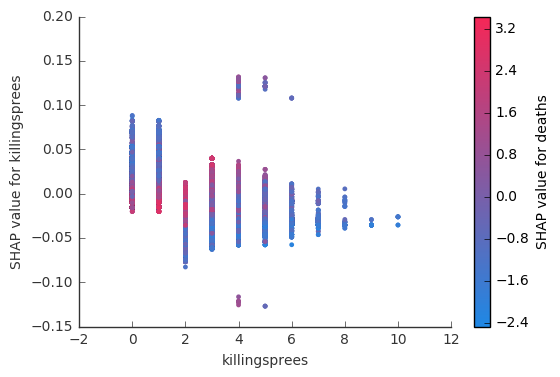

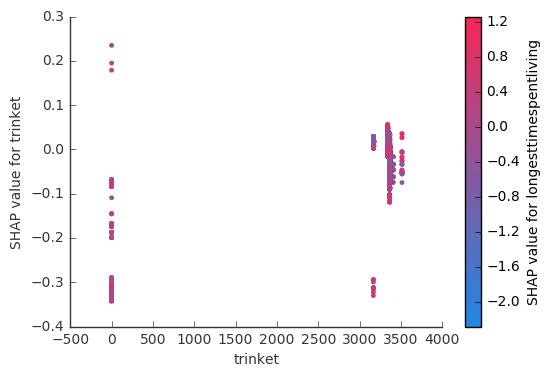

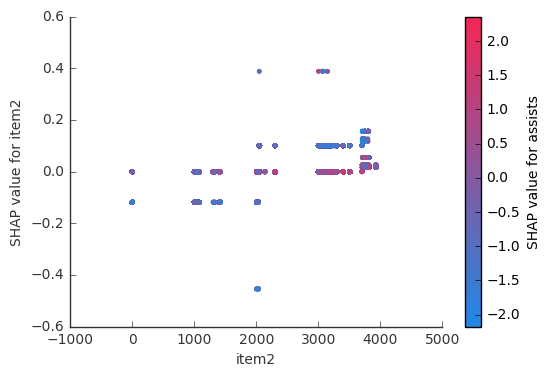

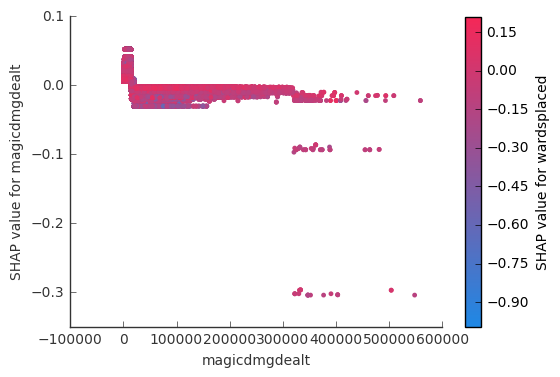

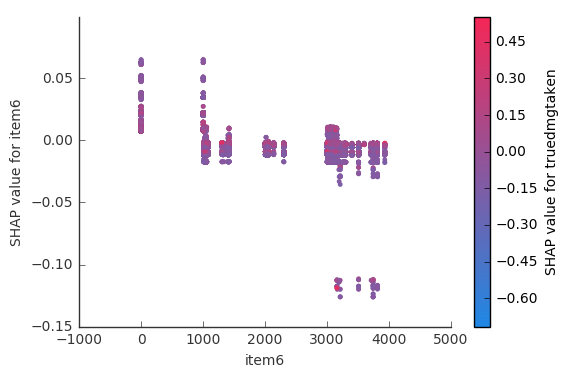

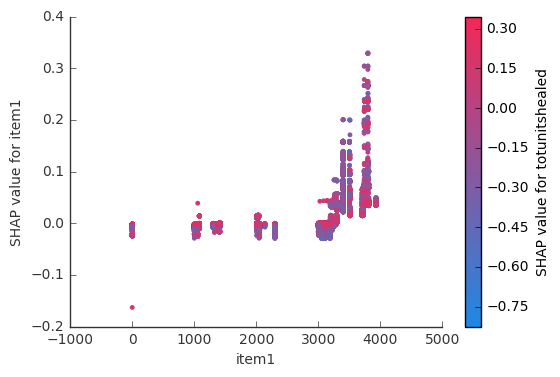

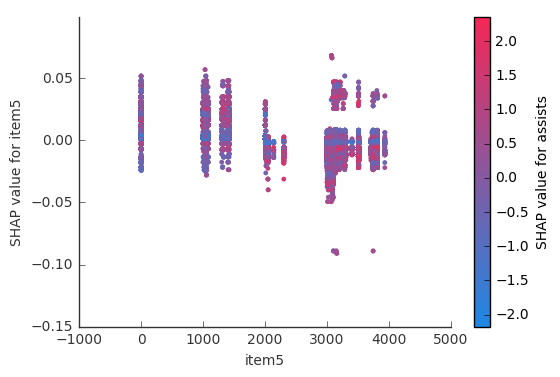

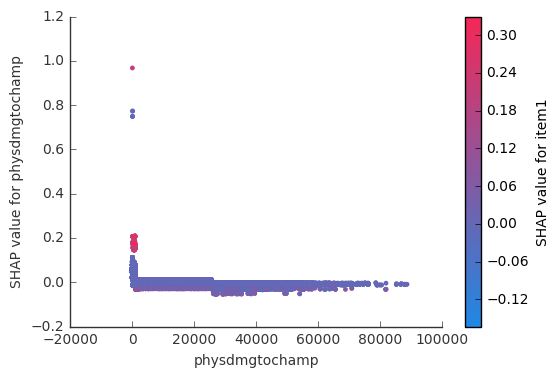

In [80]:
# make interaction SHAP plots of the ten most important features
for i in range(40):
    shap.interaction_plot(top_inds[i], Xv, shap_values)